# Example 03. Process a LEAF time-series

This example generates a Plant Area Volume Density (PAVD) profile time-series.

## Load all the required modules

In [1]:
import os
import glob
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import matplotlib

from pylidar_canopy import leaf_io, plant_profile, grid
from pylidar_canopy.rsmooth import rsmooth

## Some plotting functions

In [2]:
def plot_vertical_profiles(profiles, height, labels=['Hinge','Linear','Weighted'], title=None,
                          figsize=[6,6], ylim=(0,50), xlim=None, xlabel=r'PAVD ($m^2 m^{-3}$)'):
    """Example function to plot a vertical profile"""
    fig, ax = plt.subplots(figsize=figsize, squeeze=True)
    with plt.style.context('seaborn-talk'):
        for i,profile in enumerate(profiles):
            if labels is None:
                ax.plot(profile, height, linewidth=1.5)
            else:
                ax.plot(profile, height, label=labels[i], linewidth=1.5)
        ax.set(xlabel=xlabel, ylabel='Height (m)')
        ax.set(ylim=ylim, xlim=xlim, title=title)
        ax.set_facecolor('white')
        if labels is not None:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout() 
    plt.show()

def plot_leaf_grid(data, inset=None, label='Range (m)', clim=[0,30], figsize=(16,10), nbins=10,
                   cmap='bone', inset_cmap='Greens_r', nreturns=None, extend='max', nodata=-9999, 
                   extent=None, xlabel=None, ylabel=None, facecolor='white', title=False):
    """Example function to plot a LEAF grid"""
    if nreturns is None:
        nreturns = data.shape[0]
    fig, ax = plt.subplots(ncols=1, nrows=nreturns, squeeze=False, 
                           sharex=False, sharey=False, figsize=figsize)
    with plt.style.context('seaborn-notebook'):
        for i in range(nreturns):  
            ax[i,0].set_facecolor(facecolor)
            ax[i,0].set(adjustable='box', aspect='equal')
            ax[i,0].set(xlabel=xlabel, ylabel=ylabel)
            if title and nreturns > 1:
                ax[i,0].set_title(f'Return {i+1:d} (maximum {data.shape[0]:d})', fontsize=14)
            if extent is None:
                ax[i,0].get_xaxis().set_visible(False)
                ax[i,0].get_yaxis().set_visible(False)
            tmp = np.ma.masked_equal(data[i], nodata)
            p = ax[i,0].imshow(tmp, interpolation='none', clim=clim, 
                               cmap=matplotlib.cm.get_cmap(cmap,nbins),  
                               vmin=clim[0], vmax=clim[1], extent=extent)
            if inset is not None:
                tmp = np.ma.masked_equal(inset[i], nodata)
                pi = ax[i,0].imshow(tmp, interpolation='none', clim=clim, 
                                    cmap=matplotlib.cm.get_cmap(inset_cmap,nbins),  
                                    vmin=clim[0], vmax=clim[1], extent=extent)
            divider = make_axes_locatable(ax[i,0])
            cax = divider.append_axes('right', size='2%', pad=0.05)
            cbar = fig.colorbar(p, label=label, cax=cax, extend=extend)
            cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=nbins))
    fig.tight_layout()
    plt.show()
    
def plot_xyz(x, y, z, c, figsize=[8,8], elev=None, azim=None, cmap='viridis', xylim=(None,None)):
    """Example function to plot the LEAF point cloud""" 
    fig = plt.figure(figsize=figsize)
    with plt.style.context('seaborn-talk'):
        ax = fig.add_subplot(projection='3d')
        ax.set_box_aspect([np.ptp(x), np.ptp(y), np.ptp(z)])
        ax.scatter(x, y, z, c=c, s=3, cmap=cmap)
        ax.set(xlabel='X (m)', ylabel='Y (m)', zlabel='Z (m)', xlim=xylim, ylim=xylim)
        ax.view_init(elev, azim)
    fig.tight_layout()
    plt.show()    

def plot_timseries_2d(data, clim=[0,0.2], title=None, nbins='auto', cmap='gist_earth', 
              label=r'PAVD ($m^{2} m^{-3}$)', facecolor='0.5', extend='max', extent=None, figsize=(20,10)):
    """Example function to plot a 2D histogram of the LEAF PAVD time-series""" 
    fig, ax = plt.subplots(ncols=1, nrows=1, squeeze=True, figsize=figsize)
    with plt.style.context('seaborn-talk'):
        ax.set_facecolor(facecolor)
        ax.set(adjustable='datalim', xlabel='Date', ylabel='Height (m)')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%-d-%b-%y')
        ax.xaxis.set_major_formatter(date_format)
        if title is not None:
            ax.set_title(title)
        p = ax.imshow(data, interpolation='none', clim=clim, cmap=cmap, alpha=1.0, 
                      vmin=clim[0], vmax=clim[1], extent=extent, aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='2%', pad=0.05)
        cbar = fig.colorbar(p, label=label, cax=cax, extend=extend)
        cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=nbins))
        
    fig.tight_layout()
    plt.show()

    
def plot_timseries_1d(dates, values, quality, fitted=None, xlim=[None,None], ylim=[0,None], title=None, 
    ylabel=r'PAI ($m^{2} m^{-2}$)', linestyle=None, figsize=(20,10)):
    """Example function to plot a 2D histogram of the LEAF PAVD time-series""" 
    fig, ax = plt.subplots(ncols=1, nrows=1, squeeze=True, figsize=figsize)
    with plt.style.context('seaborn-talk'):
        ax.scatter(dates[quality], values[quality], linestyle=linestyle, color='DarkGreen', label='True')
        ax.scatter(dates[~quality], values[~quality], linestyle=linestyle, color='Brown', label='False')
        if fitted is not None:
            ax.plot(dates, fitted, linestyle=linestyle, color='Black')
        date_format = mdates.DateFormatter('%-d-%b-%y')
        ax.xaxis.set_major_formatter(date_format)
        ax.set(xlabel='Date', ylabel=ylabel)
    fig.autofmt_xdate()
    plt.legend(title='Quality')
    plt.tight_layout()
    plt.show()

## Identify all of the input files

Create a list of all files available to generate a time-series.

In [3]:
# SERC
sensor = 363
os.chdir(f'/gpfs/data1/vclgp/data/leaf/serc/01Nov22/{sensor:d}/data')
hemi_csv_list = glob.glob('ESS?????_*_hemi_*.csv')
hinge_csv_list = glob.glob('ESS?????_*_hinge_*.csv')
ground_csv_list = glob.glob('data/ESS?????_*_ground_*.csv')
power_csv_list = glob.glob('pwr/ESS?????_pwr_*.csv')

# Wytham
sensor = 301
os.chdir(f'/gpfs/data1/vclgp/data/leaf/wytham/{sensor:d}')
hemi_csv_list = glob.glob('ESS?????_*_hemi_*.csv')
hinge_csv_list = glob.glob('ESS?????_*_hinge_*.csv')

In [4]:
df = leaf_io.LeafScanFile(hemi_csv_list[1], sensor_height=1.5).data
df.head()

,sample_count,scan_encoder,rotary_encoder,range1,intensity1,range2,sample_time,target_count,datetime,zenith,azimuth,x1,y1,z1,h1,x2,y2,z2,h2
0,27,1400.0,0,1.71,100,1.69,36.21,2,2022-06-22 03:00:29.036210,2.251002,5.215698,-1.164567,0.641219,-1.075510,0.424490,-1.150946,0.633719,-1.062931,0.437069
1,28,1450.0,0,1.87,100,1.91,34.91,2,2022-06-22 03:00:29.071120,2.219586,5.215698,-1.305266,0.718689,-1.129897,0.370103,-1.333186,0.734062,-1.154065,0.345935
2,29,1500.0,0,1.92,100,1.96,35.33,2,2022-06-22 03:00:29.106450,2.188170,5.215698,-1.371426,0.755117,-1.111480,0.388520,-1.399997,0.770849,-1.134636,0.365364
3,30,1550.0,0,1.97,100,1.97,37.20,2,2022-06-22 03:00:29.143650,2.156755,5.215698,-1.437825,0.791677,-1.089406,0.410594,-1.437825,0.791677,-1.089406,0.410594
4,31,1600.0,0,2.00,100,2.00,35.85,2,2022-06-22 03:00:29.179500,2.125339,5.215698,-1.489433,0.820093,-1.053108,0.446892,-1.489433,0.820093,-1.053108,0.446892


## Visualize the 3D point cloud

Let's check the hinge angle scan is where we think it is

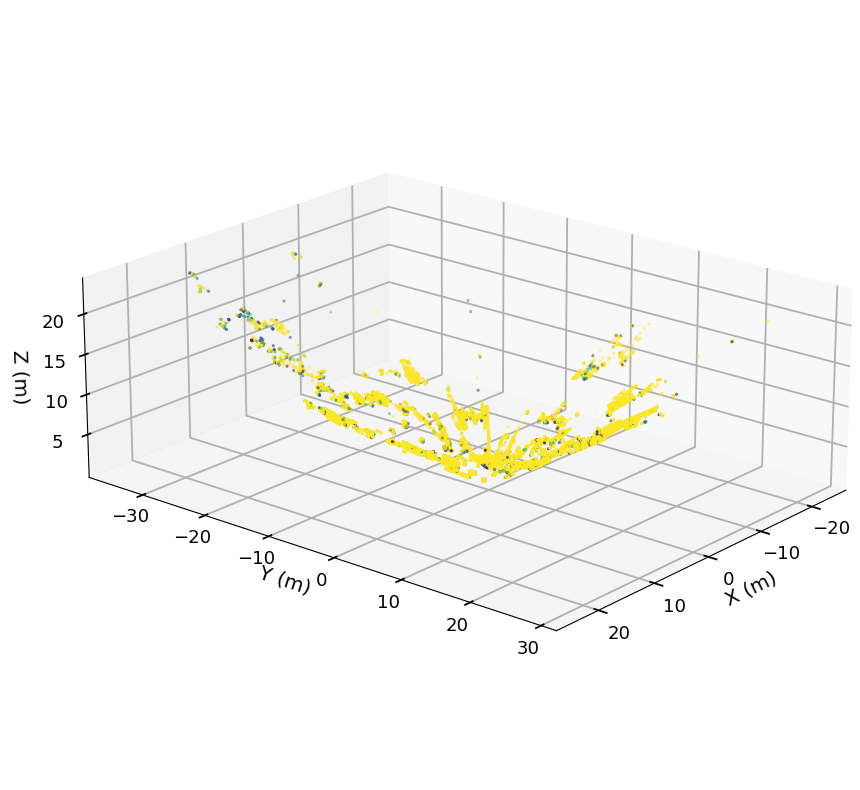

In [5]:
df = leaf_io.LeafScanFile(hinge_csv_list[0], sensor_height=1.5).data
valid = ~(np.isnan(df.x1) | np.isnan(df.y1) | np.isnan(df.z1))
plot_xyz(df.x1[valid], df.y1[valid], df.z1[valid], df.intensity1[valid], 
         figsize=[8,8], elev=20, azim=40, cmap='viridis')

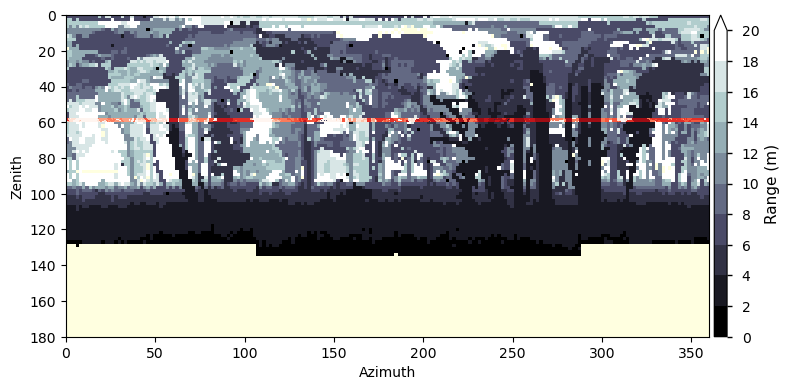

In [6]:
leaf_hemi_grid = grid.grid_leaf_spherical(hemi_csv_list[0], 1.8, attribute='range1',
    method='MIN', sensor_height=1.5)

leaf_hinge_grid = grid.grid_leaf_spherical(hinge_csv_list[0], 0.45, attribute='range1',
    method='MIN', sensor_height=1.5)

plot_leaf_grid(leaf_hemi_grid, label='Range (m)', clim=[0,20], figsize=(8,6), 
               nbins=10, cmap='bone', extent=[0,360,180,0], inset=leaf_hinge_grid,
               xlabel='Azimuth', ylabel='Zenith', facecolor='lightyellow', inset_cmap='Reds_r')

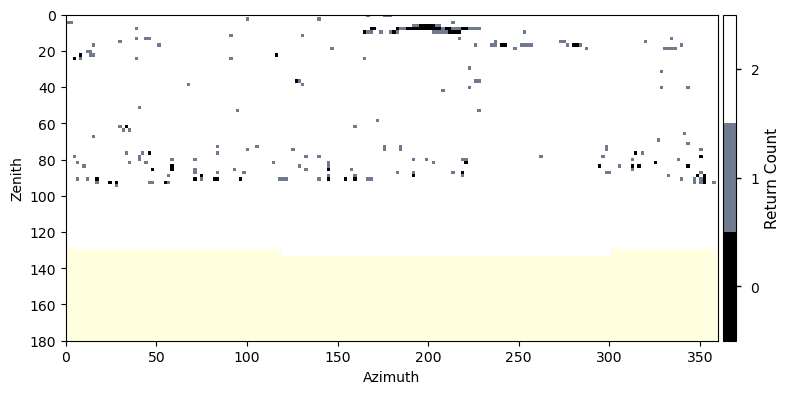

In [7]:
leaf_spherical_grid = grid.grid_leaf_spherical(hemi_csv_list[1], 1.8, attribute='target_count',
    method='MIN', sensor_height=1.5)

plot_leaf_grid(leaf_spherical_grid, label='Return Count', clim=[-0.5,2.5], figsize=(8,6), 
               nbins=3, cmap='bone', extent=[0,360,180,0], xlabel='Azimuth', 
               ylabel='Zenith', facecolor='lightyellow', extend='neither')

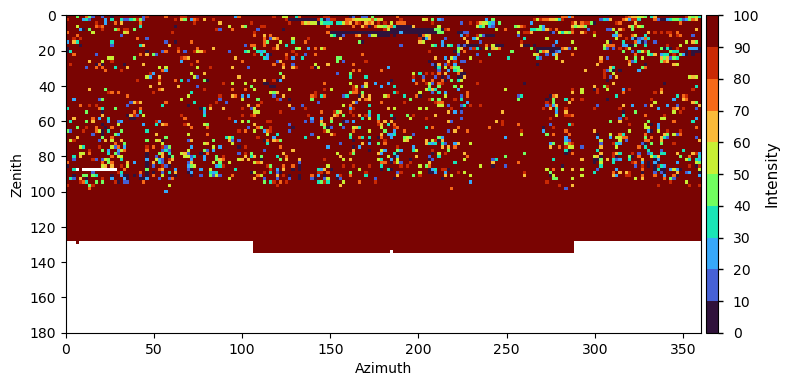

In [8]:
leaf_spherical_grid = grid.grid_leaf_spherical(hemi_csv_list[0], 1.8, attribute='intensity1',
    method='MEAN', sensor_height=1.5)

plot_leaf_grid(leaf_spherical_grid, label='Intensity', clim=[0,100], figsize=(8,6), 
               nbins=10, cmap='turbo', extent=[0,360,180,0], extend='neither',
               xlabel='Azimuth', ylabel='Zenith', facecolor='white')

## Generate $P_{gap}$ profiles for a single hemi scan

Plot the $P_{gap}$ and PAVD profiles for an example scan.

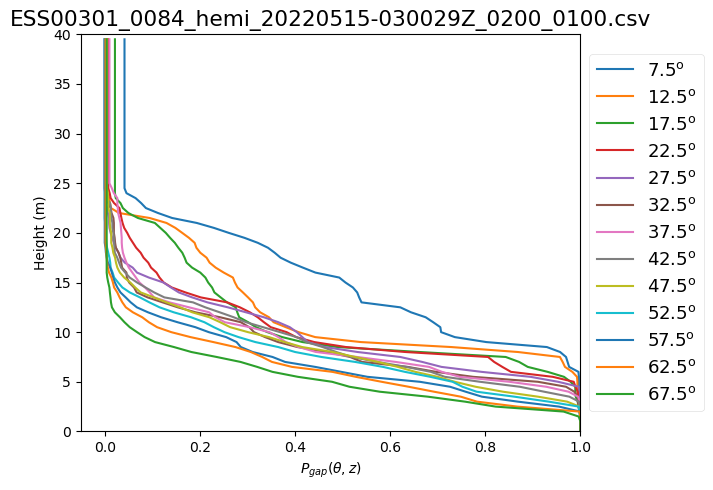

In [9]:
leaf_file = hemi_csv_list[0]
vpp = plant_profile.Jupp2009(hres=0.5, zres=5, ares=90, min_z=5, max_z=70, min_h=0, max_h=40)
valid = vpp.add_leaf_scan_position(leaf_file, method='WEIGHTED', 
                                   min_zenith=5, max_zenith=70, sensor_height=1.5)
if valid:
    vpp.get_pgap_theta_z()
    title = os.path.basename(leaf_file)
    pgap_labels = [fr'{b:.1f}$\rm ^o$' for b in vpp.zenith_bin]
    plot_vertical_profiles(vpp.pgap_theta_z, vpp.height_bin, xlabel=r'$P_{gap}(\theta,z)$',
                           labels=pgap_labels, ylim=[0,40], xlim=[None,1], figsize=[7,5], title=title)

## Compare the hinge and hemi scans for the same date

The hinge scans are designed for PAI profiles and the hemi scans for visualization of terrain and understorey structure. 
But can they produce the same vertical profiles?

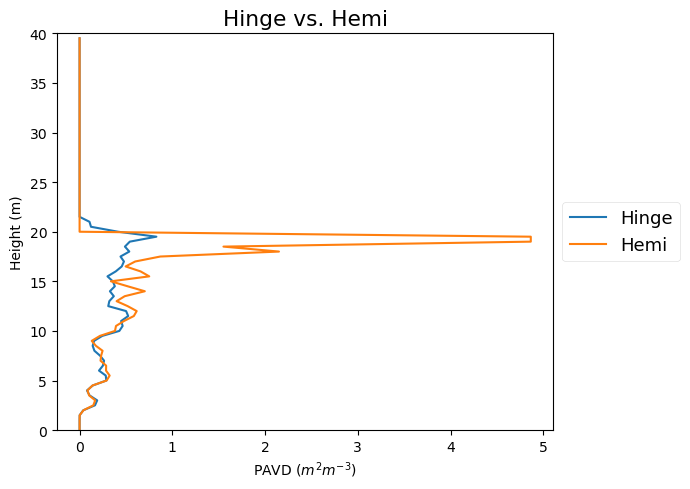

In [10]:
# SERC
hinge_file = 'ESS00301_0004_hinge_20220308-020029Z_0005_5410.csv'
hemi_file = 'ESS00301_0005_hemi_20220308-030029Z_0200_0100.csv'

# Wytham
hinge_file = 'ESS00301_0111_hinge_20220608-020029Z_0005_5410.csv'
hemi_file = 'ESS00301_0112_hemi_20220608-030029Z_0200_0100.csv'

hemi_vpp = plant_profile.Jupp2009(hres=0.5, zres=5, ares=90, min_z=55, max_z=60, min_h=0, max_h=40)
hemi_valid = hemi_vpp.add_leaf_scan_position(hemi_file, method='WEIGHTED', 
                                   min_zenith=55, max_zenith=60, sensor_height=1.5)
hemi_vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)
hemi_pai = hemi_vpp.calcHingePlantProfiles()
hemi_pavd = hemi_vpp.get_pavd(hemi_pai)

hinge_vpp = plant_profile.Jupp2009(hres=0.5, zres=5, ares=90, min_z=55, max_z=60, min_h=0, max_h=40)
hinge_valid = hinge_vpp.add_leaf_scan_position(hinge_file, method='WEIGHTED', 
                                   min_zenith=55, max_zenith=60, sensor_height=1.5)
hinge_vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)
hinge_pai = hinge_vpp.calcHingePlantProfiles()
hinge_pavd = hinge_vpp.get_pavd(hinge_pai)

plot_vertical_profiles([hinge_pavd,hemi_pavd], vpp.height_bin, 
   labels=['Hinge','Hemi'], ylim=[0,40], figsize=[7,5], title='Hinge vs. Hemi')

## Plot the PAVD time-series

Plot a PAVD time-series following filtering of observations affected by rain or other pertubations

In [11]:
hres = 0.5
max_h = 40

leaf_hinge_files = sorted(hinge_csv_list)
ncols = len(leaf_hinge_files)
nrows = int(max_h / hres)
pavd_grid = np.full((nrows,ncols), -9999, dtype=float)

In [12]:
leaf_hinge_dates = np.empty(ncols, dtype='O')
leaf_hinge_pai = np.full(ncols, np.nan, dtype=float)

for i,leaf_file in enumerate(leaf_hinge_files):
    vpp = plant_profile.Jupp2009(hres=hres, zres=5, ares=90, min_h=0, max_h=max_h)
    valid = vpp.add_leaf_scan_position(leaf_file, method='WEIGHTED', 
                                       min_zenith=55, max_zenith=60, sensor_height=1.5)
    if valid:
        vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)
        pai = vpp.calcHingePlantProfiles()
        pavd_grid[:,i] = vpp.get_pavd(pai)
        leaf_hinge_pai[i] = pai[-1]
    
    leaf_hinge_dates[i] = vpp.datetime


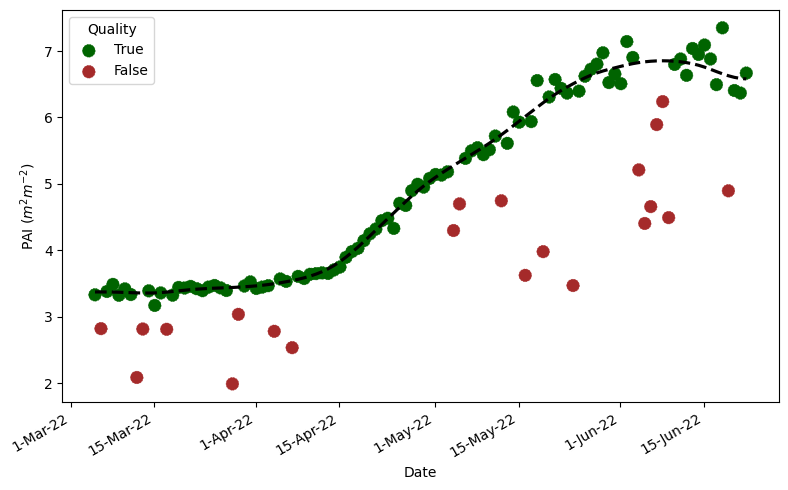

In [13]:
leaf_hinge_pai_smooth,weights = rsmooth(leaf_hinge_pai)
bad_data = (weights < 0.1) & (leaf_hinge_pai < leaf_hinge_pai_smooth)
plot_timseries_1d(leaf_hinge_dates, leaf_hinge_pai, ~bad_data, fitted=leaf_hinge_pai_smooth,
                  xlim=[None,None], ylim=[0,None], title=None, linestyle='dashed',
                  ylabel=r'PAI ($m^{2} m^{-2}$)', figsize=(8,5))

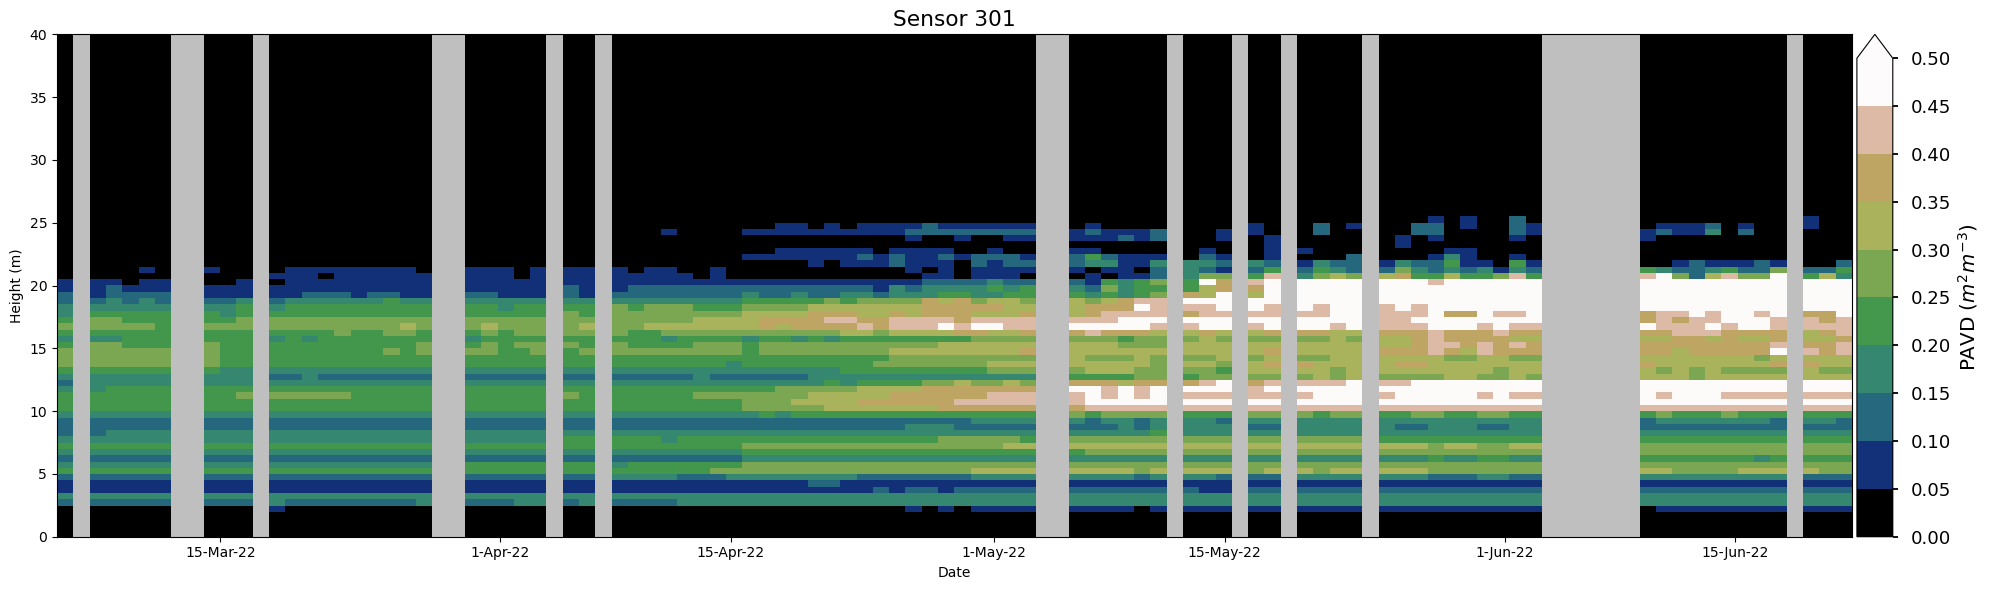

In [14]:
extent = [mdates.date2num(leaf_hinge_dates[0]),mdates.date2num(leaf_hinge_dates[-1]),0,max_h] 

pavd_grid[:,bad_data] = -9999
pavd_grid = np.ma.masked_equal(pavd_grid, -9999)

plot_timseries_2d(pavd_grid[::-1], clim=[0,0.5], title=f'Sensor {sensor:d}', nbins=10, 
                  cmap=matplotlib.cm.get_cmap('gist_earth',10), label=r'PAVD ($m^{2} m^{-3}$)', 
                  facecolor='0.75', extend='max', extent=extent, figsize=(20,6))